In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

PATH = "Z:\Laboral\World Bank\CLIENT v2"
DATA_RAW = rf"{PATH}\Data\Data_raw"
DATA_PROC = rf"{PATH}\Data\Data_proc"
DATA_OUT = rf"{PATH}\Data\Data_out"

In [16]:
test_ds2 = xr.open_dataset(r"Z:\WB Data\Global Flood Database\gfd_v1_4\DFO_1631_From_20000901_to_20000906.tif")

c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\backends\plugins.py:159: RuntimeWarning: 'ee' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


In [18]:
pop = xr.open_dataset(r"Z:\WB Data\Gridded Population of The World (GPWv4)\gpw_v4_population_count_rev11_2000_30_sec.tif")

c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\backends\plugins.py:159: RuntimeWarning: 'ee' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


In [20]:
pop

<xarray.Dataset> Size: 4GB
Dimensions:      (band: 1, x: 43200, y: 21600)
Coordinates:
  * band         (band) int32 4B 1
  * x            (x) float64 346kB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * y            (y) float64 173kB 90.0 89.99 89.98 ... -89.98 -89.99 -90.0
    spatial_ref  int32 4B ...
Data variables:
    band_data    (band, y, x) float32 4GB ...

In [21]:
pop = pop.sel(x=slice(test_ds2.x.min(), test_ds2.x.max()), y=slice(test_ds2.y.max(), test_ds2.y.min()))

<xarray.Dataset> Size: 600MB
Dimensions:      (band: 5, x: 7625, y: 3933)
Coordinates:
  * band         (band) int32 20B 1 2 3 4 5
  * x            (x) float64 61kB 102.3 102.3 102.3 102.3 ... 119.4 119.4 119.4
  * y            (y) float64 31kB 30.36 30.35 30.35 30.35 ... 21.53 21.53 21.52
    spatial_ref  int32 4B ...
Data variables:
    band_data    (band, y, x) float32 600MB ...

In [17]:
test_ds2.interp_like()

<xarray.Dataset> Size: 600MB
Dimensions:      (band: 5, x: 7625, y: 3933)
Coordinates:
  * band         (band) int32 20B 1 2 3 4 5
  * x            (x) float64 61kB 102.3 102.3 102.3 102.3 ... 119.4 119.4 119.4
  * y            (y) float64 31kB 30.36 30.35 30.35 30.35 ... 21.53 21.53 21.52
    spatial_ref  int32 4B ...
Data variables:
    band_data    (band, y, x) float32 600MB ...

In [2]:
test_ds = xr.open_dataset("Z:\WB Data\Global Flood Database\gfd_v1_4\DFO_2221_From_20030501_to_20030516.tif")

c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\backends\plugins.py:159: RuntimeWarning: 'ee' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


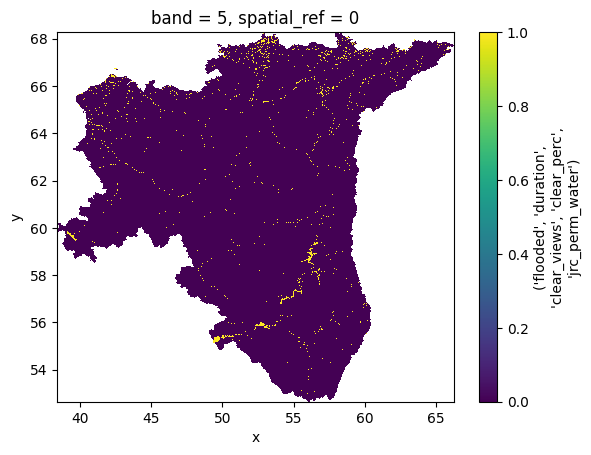

In [15]:
test_ds.sel(band=5).band_data.plot()